# Hi-C Simulation: Modeling the Active Region Geometry
Our first task is to model the active region geometry. We need to download the magnetogram from 29 May 2018 17:00:00 UTC (1 PM Eastern) and perform a field extrapolation.

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
import astropy.time
from sunpy.sun import constants
from sunpy.map import Map,GenericMap
from sunpy.net import Fido,attrs as a,vso
from sunpy.time import TimeRange
import sunpy.coordinates
from sunpy.util.metadata import MetaDict

import synthesizAR
import synthesizAR.extrapolate

%matplotlib inline

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Downloading the Data
The first step is to pull down the HMI magnetogram from JSOC.

In [8]:
q = Fido.search(a.Time(TimeRange('2018/05/29 16:59:30', '2018/05/29 17:00:30')),
                a.Instrument('HMI'), vso.attrs.Physobs('LOS_magnetic_field'))
file_path = Fido.fetch(q,)
magnetogram = Map(file_path)

[                                        ========================================


We rotate the magnetogram such that the pixel and physical dimensions are properly aligned. For some reason, the HMI data is delivered from JSOC rotated by 180$^{\circ}$

In [9]:
magnetogram = magnetogram.rotate(order=3)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


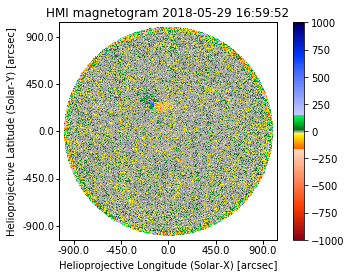

In [10]:
magnetogram.peek(vmin=-1e3,vmax=1e3,cmap='hmimag')
plt.show()

In [12]:
blc = SkyCoord(-375*u.arcsec, 50*u.arcsec, frame=magnetogram.coordinate_frame)
trc = SkyCoord(150*u.arcsec, 500*u.arcsec, frame=magnetogram.coordinate_frame)

In [14]:
magnetogram_ar = magnetogram.submap(blc,trc)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


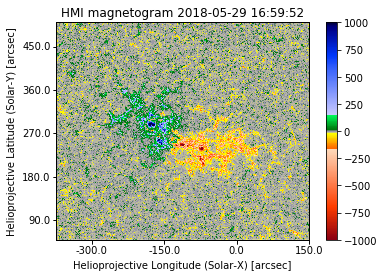

In [15]:
magnetogram_ar.peek(vmin=-1e3,vmax=1e3,cmap='hmimag')
plt.show()

In [16]:
magnetogram_ar_resampled = magnetogram_ar.resample([125,125]*u.pixel)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


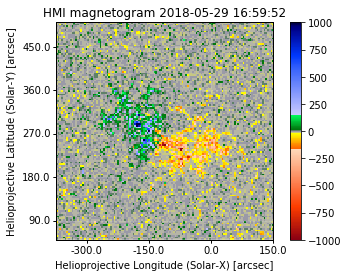

In [17]:
magnetogram_ar_resampled.peek(vmin=-1e3,vmax=1e3,cmap='hmimag')
plt.show()

## Extrapolating the Field

In [18]:
shape_z = 125*u.pixel
width_z = 0.3*const.R_sun
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram_ar_resampled,width_z,shape_z)
B_field = extrapolator.extrapolate()

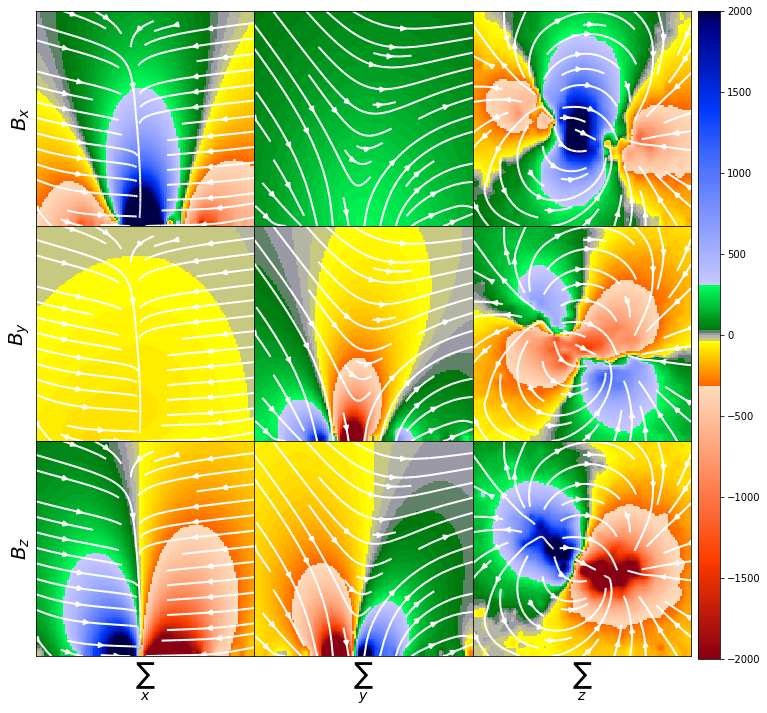

In [19]:
synthesizAR.extrapolate.peek_projections(B_field)

## Tracing Fieldlines

In [36]:
fieldlines_pos = extrapolator.trace_fieldlines(B_field,500,close_threshold=0.05,mask_threshold=0.1,direction=1,
                                               loop_length_range=[10,500]*u.Mm)

yt : [INFO     ] 2018-06-04 00:19:05,930 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-06-04 00:19:05,931 Parameters: domain_dimensions         = [125 125 125]
yt : [INFO     ] 2018-06-04 00:19:05,932 Parameters: domain_left_edge          = [-1.93699376e+10 -1.57721722e+10  0.00000000e+00]
yt : [INFO     ] 2018-06-04 00:19:05,934 Parameters: domain_right_edge         = [1.81399592e+10 1.87530121e+10 2.08710000e+10]
yt : [INFO     ] 2018-06-04 00:19:05,936 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-06-04 00:19:06,742 AMRKDTree rebuilt, Final Volume: 2.702870e+31
Streamlining: 100%|██████████| 500/500 [00:01<00:00, 326.04it/s]
yt : [INFO     ] 2018-06-04 00:19:09,151 AMRKDTree rebuilt, Final Volume: 2.702870e+31
Streamlining: 100%|██████████| 76/76 [00:00<00:00, 263.74it/s]
yt : [INFO     ] 2018-06-04 00:19:10,116 AMRKDTree rebuilt, Final Volume: 2.702870e+31
Streamlining: 100%|██████████| 17/17 [00:00<00:00, 196.92it/s]
yt : [INFO     ] 2018-06

FloatProgress(value=0.0)

In [37]:
fieldlines_neg = extrapolator.trace_fieldlines(B_field,500,close_threshold=0.05,mask_threshold=-0.1,direction=-1,
                                               loop_length_range=[10,500]*u.Mm)

yt : [INFO     ] 2018-06-04 00:19:33,740 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-06-04 00:19:33,741 Parameters: domain_dimensions         = [125 125 125]
yt : [INFO     ] 2018-06-04 00:19:33,742 Parameters: domain_left_edge          = [-1.93699376e+10 -1.57721722e+10  0.00000000e+00]
yt : [INFO     ] 2018-06-04 00:19:33,743 Parameters: domain_right_edge         = [1.81399592e+10 1.87530121e+10 2.08710000e+10]
yt : [INFO     ] 2018-06-04 00:19:33,744 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-06-04 00:19:34,550 AMRKDTree rebuilt, Final Volume: 2.702870e+31
Streamlining: 100%|██████████| 500/500 [00:02<00:00, 219.55it/s]
yt : [INFO     ] 2018-06-04 00:19:37,692 AMRKDTree rebuilt, Final Volume: 2.702870e+31
Streamlining: 100%|██████████| 226/226 [00:00<00:00, 251.35it/s]
yt : [INFO     ] 2018-06-04 00:19:39,216 AMRKDTree rebuilt, Final Volume: 2.702870e+31
Streamlining: 100%|██████████| 88/88 [00:00<00:00, 244.58it/s]
yt : [INFO     ] 2018-

FloatProgress(value=0.0)

In [38]:
active_region = synthesizAR.Field(magnetogram_ar_resampled,fieldlines_pos+fieldlines_neg)

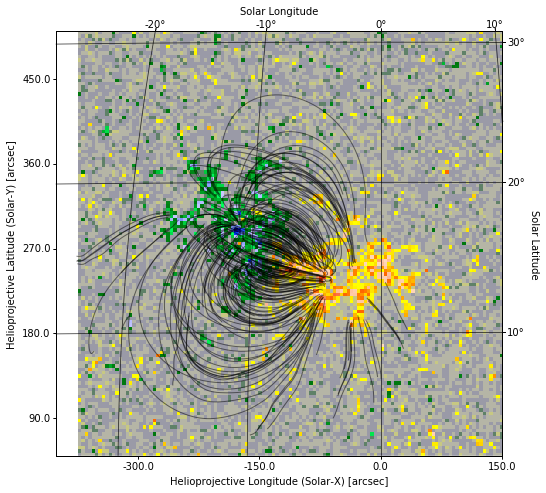

In [40]:
active_region.peek(line_frequency=4)

In [41]:
active_region.loops[0]

Name : loop000000
Loop full-length, 2L : 91.675 Mm
Footpoints : (6.46e+10 cm,-1.93e+10 cm,2.11e+10 cm),(6.47e+10 cm,-2.74e+10 cm,1.75e+10 cm)
Maximum field strength : 58.87 G